In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split, unary_union
from shapely.affinity import scale
from shapely.geometry import mapping

In [11]:
# -------------------------
# Helpers
# -------------------------
def rect(xmin, ymin, xmax, ymax):
    return Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)])

def semicircle(center=(0, 0), radius=40, n=220):
    cx, cy = center
    angles = np.linspace(0, np.pi, n)  # semicírculo hacia y positivo
    arc = [(cx + radius*np.cos(a), cy + radius*np.sin(a)) for a in angles]
    pts = [(cx - radius, cy)] + arc + [(cx + radius, cy), (cx - radius, cy)]
    return Polygon(pts)

def ray_from_origin(angle_rad, length=2000):
    return LineString([(0, 0), (length*np.cos(angle_rad), length*np.sin(angle_rad))])

def circle(radius, resolution=256):
    return Point(0, 0).buffer(radius, resolution=resolution)

def flip_geom(g):
    # tu flip: (x,y) -> (-x,-y)
    return scale(g, xfact=-1, yfact=-1, origin=(0, 0))

def safe_union(geoms):
    geoms = [g for g in geoms if g is not None and not g.is_empty]
    return unary_union(geoms) if geoms else None

def split_lr_center(poly, left_ray, right_ray, x_center_band=30):
    if poly is None or poly.is_empty:
        return None, None, None

    parts = list(split(poly, left_ray).geoms)
    pieces = []
    for p in parts:
        pieces.extend(list(split(p, right_ray).geoms))

    L = [g for g in pieces if g.centroid.x < -x_center_band]
    C = [g for g in pieces if -x_center_band <= g.centroid.x <= x_center_band]
    R = [g for g in pieces if g.centroid.x > x_center_band]

    return safe_union(L), safe_union(C), safe_union(R)

def export_geojson(zones, out_path):
    fc = {"type": "FeatureCollection", "features": []}
    for zone_id, zone_name, geom in zones:
        fc["features"].append({
            "type": "Feature",
            "properties": {"zone_id": zone_id, "zone_name": zone_name},
            "geometry": mapping(geom)
        })
    with open(out_path, "w") as f:
        json.dump(fc, f)


In [12]:
# -------------------------
# 1) Base court (sistema normal)
# -------------------------
X_MIN, X_MAX = -250, 250
Y_MIN, Y_MAX = -52, 422.5
HALFCOURT = rect(X_MIN, Y_MIN, X_MAX, Y_MAX)

# Paint y RA
PAINT = rect(-80, Y_MIN, 80, 142.5)
RA = semicircle(radius=40)
PAINT_NO_RA = PAINT.difference(RA)

# -------------------------
# 2) 3PT (FORMA CORRECTA)
# -------------------------
R3 = 237.5
CORNER_X = 219

# intersección exacta del círculo con x=±CORNER_X
CORNER_Y = float((R3**2 - CORNER_X**2) ** 0.5)

# corners = strips laterales hasta CORNER_Y
CORNER_L = rect(X_MIN, Y_MIN, -CORNER_X, CORNER_Y)
CORNER_R = rect(CORNER_X, Y_MIN, X_MAX, CORNER_Y)
CORNERS = unary_union([CORNER_L, CORNER_R])

# círculo del arco de 3 (recortado a media cancha)
C3 = circle(R3, resolution=512)
INSIDE_ARC = HALFCOURT.intersection(C3)      # dentro del arco (2pt "normal")
OUTSIDE_ARC = HALFCOURT.difference(INSIDE_ARC)  # fuera del arco (3pt above-the-break)

# 3pt total = outside arc + corners
ATB3 = OUTSIDE_ARC.difference(CORNERS)
THREEPT = ATB3.union(CORNERS)

# 2pt total = halfcourt - threept
TWOPT = HALFCOURT.difference(THREEPT)

# -------------------------
# 3) “Gajos” / splits L-C-R
# -------------------------
left_split = ray_from_origin(np.deg2rad(119))
right_split = ray_from_origin(np.deg2rad(61))

# 3pt above-the-break L/C/R
ATB3_L, ATB3_C, ATB3_R = split_lr_center(ATB3, left_split, right_split, x_center_band=30)

# -------------------------
# 4) Midrange interno (short/long) + L/C/R
# -------------------------
# Ajusta estos radios a tu gusto (son los que controlan "zonas interiores")
R_INNER = 80     # cerca a pintura (fuera)
R_MID   = 165    # frontera short/long
# R_OUTER = R3   # límite superior (arco)

C_INNER = circle(R_INNER, resolution=256)
C_MID   = circle(R_MID, resolution=256)

# Dentro del arco (zona de 2pt "normal") excluyendo corners ya viene implícito
# Short ring: 80..160 dentro del arco y en halfcourt
SHORT_RING = HALFCOURT.intersection(C_MID).difference(HALFCOURT.intersection(C_INNER))
# Long ring: 160..R3 dentro del arco
LONG_RING  = INSIDE_ARC.difference(HALFCOURT.intersection(C_MID))

# Midrange = (2pt) fuera de paint
SHORT_MR = TWOPT.intersection(SHORT_RING).difference(PAINT)
LONG_MR  = TWOPT.intersection(LONG_RING).difference(PAINT)

SMR_L, SMR_C, SMR_R = split_lr_center(SHORT_MR, left_split, right_split, x_center_band=30)
LMR_L, LMR_C, LMR_R = split_lr_center(LONG_MR, left_split, right_split, x_center_band=30)

BACKCOURT = rect(-250, 422.5, 250, 1000)

# -------------------------
# 5) Paint subzonas (RA + low/high)
# -------------------------
paint_split_y = 60
paint_split_line = LineString([(-100, paint_split_y), (100, paint_split_y)])
paint_parts = list(split(PAINT_NO_RA, paint_split_line).geoms)

P_LOW  = safe_union([g for g in paint_parts if g.centroid.y < paint_split_y])
P_HIGH = safe_union([g for g in paint_parts if g.centroid.y >= paint_split_y])

# -------------------------
# 6) Zonas (sistema normal) -> flip -> export
# -------------------------
zones_normal = [
    ("RA", "Restricted Area", RA),
    ("P_LOW", "Paint Low (no RA)", P_LOW),
    ("P_HIGH", "Paint High (no RA)", P_HIGH),

    ("C3_L", "Corner 3 Left", CORNER_L),
    ("C3_R", "Corner 3 Right", CORNER_R),

    ("ATB3_L", "Above Break 3 Left", ATB3_L),
    ("ATB3_C", "Above Break 3 Center", ATB3_C),
    ("ATB3_R", "Above Break 3 Right", ATB3_R),

    ("SMR_L", "Short Midrange Left", SMR_L),
    ("SMR_C", "Short Midrange Center", SMR_C),
    ("SMR_R", "Short Midrange Right", SMR_R),

    ("LMR_L", "Long Midrange Left", LMR_L),
    ("LMR_C", "Long Midrange Center", LMR_C),
    ("LMR_R", "Long Midrange Right", LMR_R),
    ("BACKCOURT", "Backcourt", BACKCOURT),
]

zones_normal = [(zid, zname, g) for (zid, zname, g) in zones_normal if g is not None and not g.is_empty]
zones_flip = [(zid, zname, flip_geom(g)) for (zid, zname, g) in zones_normal]

export_geojson(zones_flip, "/home/fernando/nba-analytics-pipeline/src/data/zones/zones_flipped.geojson")
print("Listo: zones_flipped.geojson")


Listo: zones_flipped.geojson


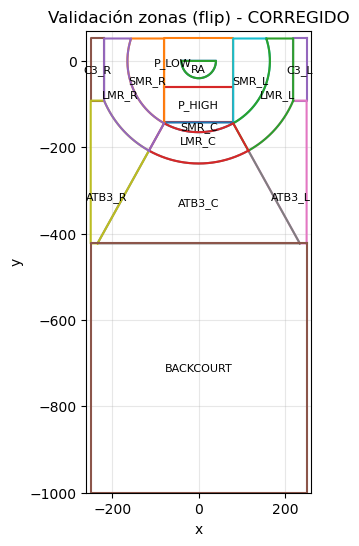

In [13]:
# -------------------------
# 7) Validación: plot SOLO polígonos (incluye interiores)
# -------------------------
def plot_polygons(zones, title="Zonas (solo polígonos)", show_labels=True):
    fig, ax = plt.subplots(figsize=(7, 6))

    for zid, zname, geom in zones:
        # Polygon o MultiPolygon
        geoms = [geom] if geom.geom_type == "Polygon" else list(geom.geoms)

        for g in geoms:
            # exterior
            x, y = g.exterior.xy
            ax.plot(x, y)
            # holes (interiores)
            for hole in g.interiors:
                hx, hy = hole.xy
                ax.plot(hx, hy)

        if show_labels:
            p = geom.representative_point()
            ax.text(p.x, p.y, zid, ha="center", va="center", fontsize=8)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.3)

    # límites típicos en tu orientación flip (como tu captura)
    ax.set_xlim(-260, 260)
    ax.set_ylim(-1000, 70)
    plt.show()

plot_polygons(zones_flip, title="Validación zonas (flip) - CORREGIDO", show_labels=True)

In [14]:
BACKCOURT = rect(-250, 422.5, 250, 500)

In [15]:
zones_normal = [
    ("RA", "Restricted Area", RA),
    ("P_LOW", "Paint Low (no RA)", P_LOW),
    ("P_HIGH", "Paint High (no RA)", P_HIGH),

    ("C3_L", "Corner 3 Left", CORNER_L),
    ("C3_R", "Corner 3 Right", CORNER_R),

    ("ATB3_L", "Above Break 3 Left", ATB3_L),
    ("ATB3_C", "Above Break 3 Center", ATB3_C),
    ("ATB3_R", "Above Break 3 Right", ATB3_R),

    ("SMR_L", "Short Midrange Left", SMR_L),
    ("SMR_C", "Short Midrange Center", SMR_C),
    ("SMR_R", "Short Midrange Right", SMR_R),

    ("LMR_L", "Long Midrange Left", LMR_L),
    ("LMR_C", "Long Midrange Center", LMR_C),
    ("LMR_R", "Long Midrange Right", LMR_R),
    ("BACKCOURT", "Backcourt", BACKCOURT),
]

zones_normal_visual = [(zid, zname, g) for (zid, zname, g) in zones_normal if g is not None and not g.is_empty]
zones_flip_visual = [(zid, zname, flip_geom(g)) for (zid, zname, g) in zones_normal]

export_geojson(zones_flip_visual, "/home/fernando/nba-analytics-pipeline/src/data/zones/zones_flipped_visual.geojson")
print("Listo: zones_flipped_visual.geojson")

Listo: zones_flipped_visual.geojson


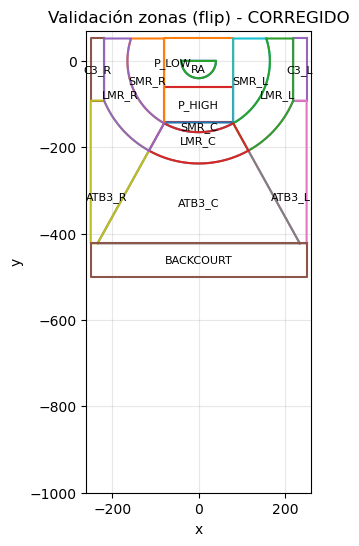

In [16]:
plot_polygons(zones_flip_visual, title="Validación zonas (flip) - CORREGIDO", show_labels=True)

In [17]:
def export_geojson(zones, out_path):
    fc = {"type": "FeatureCollection", "features": []}
    for zone_id, zone_name, geom in zones:
        # Punto garantizado dentro del polígono (mejor que centroid para formas raras)
        rp = geom.representative_point()

        fc["features"].append({
            "type": "Feature",
            "properties": {
                "zone_id": zone_id,
                "zone_name": zone_name,
                "label_x": float(rp.x),
                "label_y": float(rp.y)
            },
            "geometry": mapping(geom)
        })
    with open(out_path, "w") as f:
        json.dump(fc, f)


In [18]:
export_geojson(zones_flip_visual, "/home/fernando/nba-analytics-pipeline/src/data/zones/zones_flipped_visual_labeled.geojson")
print("Listo: zones_flipped_labeled.geojson")

Listo: zones_flipped_labeled.geojson
